# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = "data-set/train.p"
validation_file="data-set/valid.p"
testing_file = "data-set/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_orig, y_train_orig = train['features'], train['labels']
X_valid_orig, y_valid_orig = valid['features'], valid['labels']
X_test_orig, y_test_orig = test['features'], test['labels']

print (len(X_train_orig),len(y_train_orig))
print (X_valid_orig[0].shape)

34799 34799
(32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The size of training set is 34799
The size of the validation set is 4410
The size of test set is 12630
The shape of a traffic sign image is (32, 32, 3)
The number of unique classes/labels in the data set is 43

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [25]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

n_train = X_train_orig.shape[0]
n_validation = X_valid_orig.shape[0]
n_test = X_test_orig.shape[0]

image_shape = (X_train_orig.shape[1:4])
n_classes = np.unique(y_train_orig).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Here is an exploratory visualization of the data set.

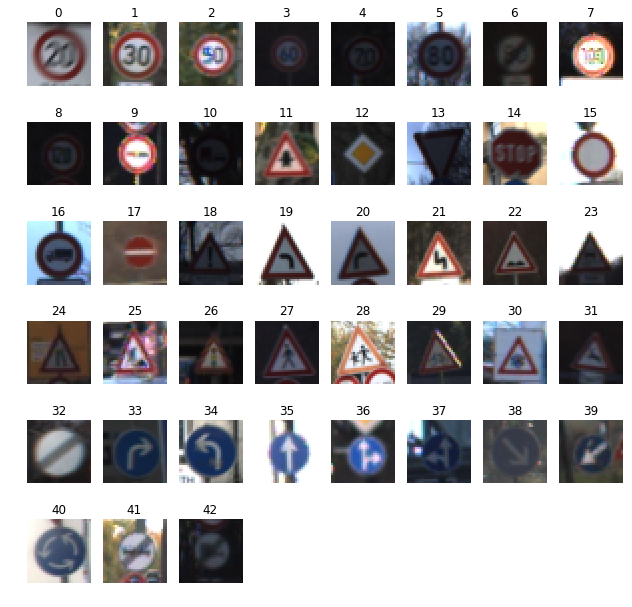

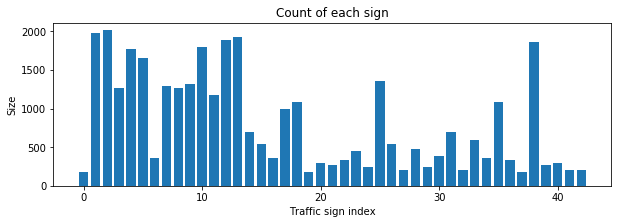

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random

# Visualizations will be shown in the notebook.
%matplotlib inline
plt.figure(figsize=(image_shape[0]/3,image_shape[1]/3))
counts=[0]*n_classes
for i in range(0, n_classes):
    plt.subplot(6, 8, i+1)
    pics = X_train_orig[y_train_orig == i]
    index = random.randint(0, len(pics))
    plt.imshow(pics[index].squeeze())
    plt.title(i)
    plt.axis('off')
    counts[i]=len(pics)
plt.show()

plt.figure(figsize=(10,3))
plt.bar(range(0, n_classes), counts)
plt.title("Count of each sign")
plt.xlabel("Traffic sign index")
plt.ylabel("Size")
plt.show()

----

## Step 2: Design and Test a Model Architecture
### Pre-process the Data Set 
The image data is normalized so that the data has mean zero and equal variance. The following equation is used to normalize the images   
`(pixel - 128)/ 128`

In [22]:
### Preprocessing

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
def normalize(data):
    return (data - 128.) / 128.

def label_binarizer(labels):
    lb = preprocessing.LabelBinarizer()
    lb.fit(labels)
    return lb

def preprocess(x_train, y_train, x_test, y_test):
    # Normalize
    x_train = normalize(x_train)
    x_test = normalize(x_test)
    
    
    # One hot encode labels
    lb = label_binarizer(y_train)
    y_train = lb.transform(y_train)
    y_test = lb.transform(y_test)
    
    # Split training set to training and validation
    x_train, x_val, y_train, y_val = \
        train_test_split(x_train, y_train, 
                         test_size=0.33, stratify = y_train ) 
    return x_train, y_train, x_test, y_test, x_val, y_val

X_train, y_train, X_test, y_test, X_val, y_val = \
preprocess(X_train_orig, y_train_orig, \
           X_test_orig, y_test_orig)

print("X_train \t y_train \t X_val \t\t y_val \t\t X_test \t y_test")
print(X_train_orig.shape,y_train.shape,\
      X_valid_orig.shape,y_valid_orig.shape,\
      X_test_orig.shape, y_test_orig.shape)
print(X_train.shape,y_train.shape,\
      X_val.shape,y_val.shape,\
      X_test.shape, y_test.shape)

X_train 	 y_train 	 X_val 		 y_val 		 X_test 	 y_test
(34799, 32, 32, 3) (23315, 43) (4410, 32, 32, 3) (4410,) (12630, 32, 32, 3) (12630,)
(23315, 32, 32, 3) (23315, 43) (11484, 32, 32, 3) (11484, 43) (12630, 32, 32, 3) (12630, 43)


### Model Architecture

My final model consisted of the following layers:

| Layer         		|     Description	        					| 
|:---------------------:|:---------------------------------------------:| 
| Input         		| 32x32x3 RGB image   							| 
| Convolution 5x5     	| 3x3 stride, VALID padding, outputs 28x28x6 	|
| RELU					|												|
| Dropout				| 50%											|
| Max pooling	      	| 2x2 stride,  outputs 14x14x6 					|
| Convolution 5x5     	| 3x3 stride, VALID padding, outputs 10x10x16 	|
| RELU					|												|
| Dropout				| 50%											|
| Max pooling	      	| 2x2 stride,  outputs 5x15x6 					|
| Flatten				| outputs 400  									|
| Fully connected		| outputs 120  									|
| RELU					|												|
| Dropout				| 50%											|
| Fully connected		| outputs 43  									|
| Softmax				|             									|

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten
import tensorflow as tf

def LeNet(x, keep_prob): 
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.01
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 43.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, n_classes), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    
    return logits

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.float32, (None, n_classes))
keep_prob = tf.placeholder(tf.float32)

logits = LeNet(x,keep_prob)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
opt = tf.train.AdamOptimizer(learning_rate=0.001) 
train_op = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [17]:
def next_batch(x_data, y_data, batch_size, step):
    batch_start = step*batch_size
    batch_x = x_data[batch_start:batch_start + batch_size]
    batch_y = y_data[batch_start:batch_start + batch_size]
    return batch_x, batch_y

def eval_data(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss,accuracy = sess.run([loss_op,accuracy_op], \
                            feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples

### Train, Validate and Test the Model

validation set accuracy of 0.961
test set accuracy of 0.895

In [23]:
EPOCHS = 10
BATCH_SIZE = 50

prob_step=(1.0-0.5)/EPOCHS
prob=1.0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    steps_per_epoch = len(X_train) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE

    for i in range(EPOCHS):
        for step in range(steps_per_epoch):
            batch_x, batch_y = next_batch(X_train, y_train, BATCH_SIZE, step)
            loss = sess.run(train_op, \
                            feed_dict={x: batch_x, y: batch_y, keep_prob: prob})

        val_loss, val_acc = eval_data(X_val, y_val)
        print("EPOCH {} keep_prob {:.2f} loss = {:.3f} accuracy = {:.3f}".
              format(i+1,prob, val_loss, val_acc))
        prob-=prob_step
        saver.save(sess, './lenet')
        
    # Evaluate on the test data
    test_loss, test_acc = eval_data(X_test, y_test)
    print()
    print("Testing model loss = {:.3f} accuracy = {:.3f}".format(test_loss, test_acc))

EPOCH 1 keep_prob 1.00 loss = 1.451 accuracy = 0.553
EPOCH 2 keep_prob 0.95 loss = 0.527 accuracy = 0.866
EPOCH 3 keep_prob 0.90 loss = 0.307 accuracy = 0.924
EPOCH 4 keep_prob 0.85 loss = 0.230 accuracy = 0.949
EPOCH 5 keep_prob 0.80 loss = 0.194 accuracy = 0.962
EPOCH 6 keep_prob 0.75 loss = 0.213 accuracy = 0.965
EPOCH 7 keep_prob 0.70 loss = 0.188 accuracy = 0.966
EPOCH 8 keep_prob 0.65 loss = 0.238 accuracy = 0.969
EPOCH 9 keep_prob 0.60 loss = 0.280 accuracy = 0.970
EPOCH 10 keep_prob 0.55 loss = 0.390 accuracy = 0.961

Testing model loss = 0.565 accuracy = 0.895


In [ ]:
# Evaluate again for comparing multiple runs
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_loss, test_acc = eval_data(X_test, y_test)
    print()
    print("Testing model loss = {:.3f} accuracy = {:.3f}".format(test_loss, test_acc))

---

## Step 3: Test a Model on New Images

I also tested the model on [official GTSRB test set](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads), which more than 10,000 pictures. I only selected the first 1000 pictures as it takes a long time to run through all the data. The prediction accuracy is 0.864.

### Load and Output the Images

Loaded  1000 files
Showing the first 20 pictures


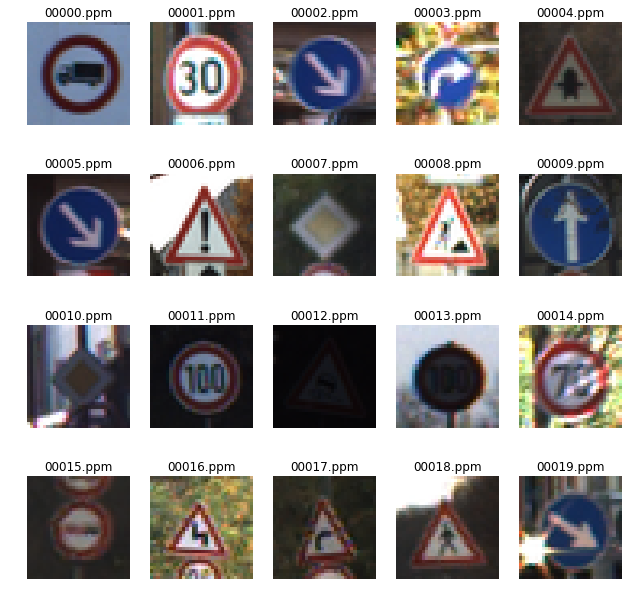

In [40]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.image as mpimg
import PIL
from PIL import Image

path = "GTSRB/Final_Test/Images/"
files = [file for file in os.listdir(path) if file.endswith('.ppm')]
files = sorted(files)
files = files[0:1000]
signs = np.empty((0,32,32,3))
file_num=len(files)

for file in files:
    img = Image.open(path + file)
    img_resized = img.resize((32,32), PIL.Image.ANTIALIAS)
    img_array=np.array(img_resized.getdata()).\
                reshape(img_resized.size[0], img_resized.size[1], 3)
    signs = np.append(signs, [img_array], axis=0)

print("Loaded ",file_num, "files")
print("Showing the first 20 pictures")


plt.figure(figsize=(image_shape[0]/3,image_shape[1]/3))
image_list=[]
for i in range(0,20) :
    img = Image.open(path + files[i])
    img_resized = img.resize((32,32), PIL.Image.ANTIALIAS)
    image_list.append(img_resized)
    plt.subplot(4, 5, i+1)
    plt.title(files[i])
    plt.imshow(img_resized)
    plt.axis('off')
plt.show()

### Predict the Sign Type for Each Image

Tested against  1000 files


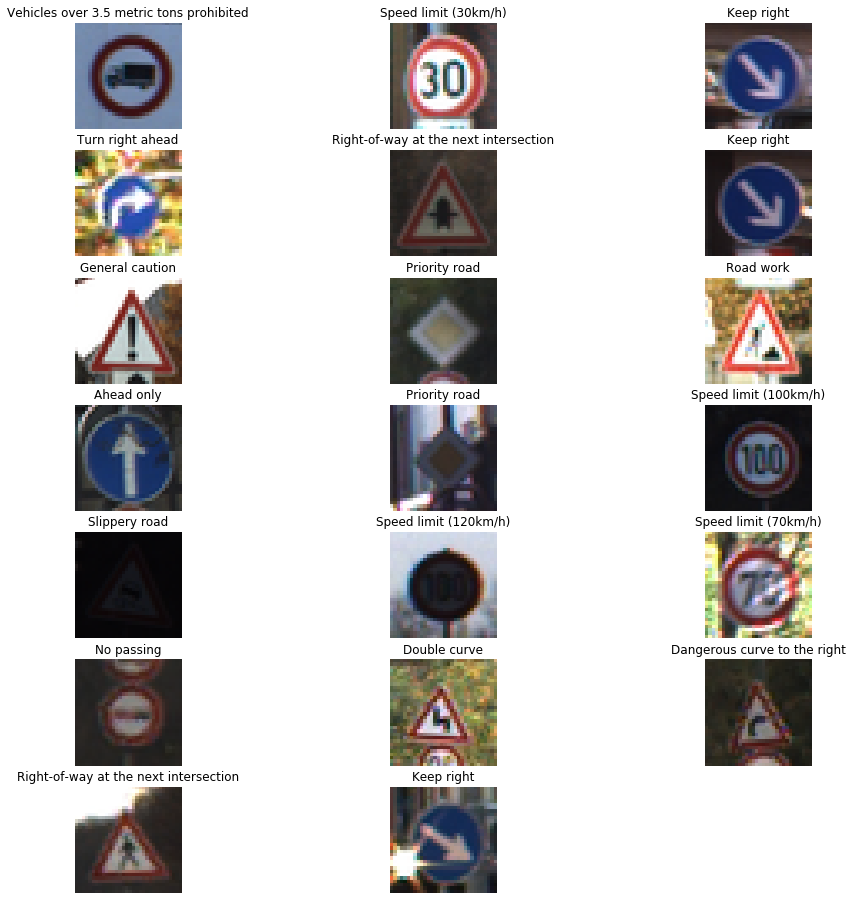

In [46]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
csv_data = np.genfromtxt('signnames.csv', delimiter=',', names=True, dtype=None)
sign_names = [t[1].decode('utf-8') for t in csv_data]

signs_norm = normalize(signs)
predicions = tf.argmax(logits,1)
predicted_classes = []

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predicted_classes = sess.run(predicions, feed_dict={x: signs_norm, keep_prob: 1.0})

print("Tested against ",len(predicted_classes),"files")
plt.figure(figsize=(image_shape[0]/2,image_shape[1]/2))
for i in range(0,20):
    plt.subplot(7, 3, i+1)
    plt.title(sign_names[predicted_classes[i]])
    plt.axis('off')
    plt.imshow(image_list[i])
plt.show()

### Analyze Performance

In [42]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
csv_data = np.genfromtxt('GTSRB/Final_Test/GT-final_test.csv', \
                         delimiter=';', names=True, dtype=None)
label_indexed= [l[7] for l in csv_data]
for i in range(0,20):
    print(predicted_classes[i],"\t",label_indexed[i],"\t",\
          sign_names[label_indexed[i]])
    
correct_predicts=0
for predict,label in zip(predicted_classes,label_indexed):
    if predict==label:
        correct_predicts+=1
        
print()
print("Correct predict: ",correct_predicts)
print("Total test: ",file_num)
print("Accuracy: ",1.0* correct_predicts/file_num)

16 	 16 	 Vehicles over 3.5 metric tons prohibited
1 	 1 	 Speed limit (30km/h)
38 	 38 	 Keep right
33 	 33 	 Turn right ahead
11 	 11 	 Right-of-way at the next intersection
38 	 38 	 Keep right
18 	 18 	 General caution
12 	 12 	 Priority road
25 	 25 	 Road work
35 	 35 	 Ahead only
12 	 12 	 Priority road
7 	 7 	 Speed limit (100km/h)
23 	 23 	 Slippery road
8 	 7 	 Speed limit (100km/h)
4 	 4 	 Speed limit (70km/h)
9 	 9 	 No passing
21 	 21 	 Double curve
20 	 20 	 Dangerous curve to the right
11 	 27 	 Pedestrians
38 	 38 	 Keep right

Correct predict:  864
Total test:  1000
Accuracy:  0.864


### Output Top 5 Softmax Probabilities For Each Image

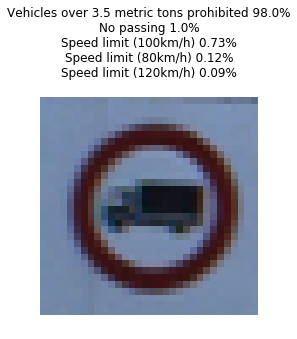

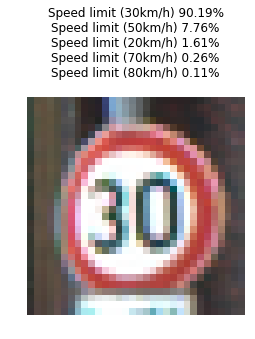

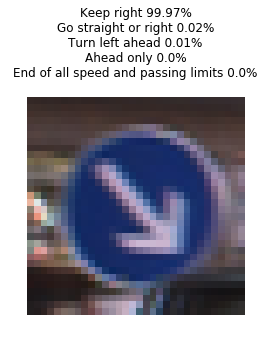

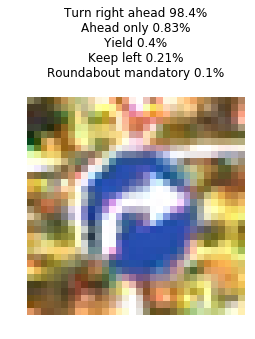

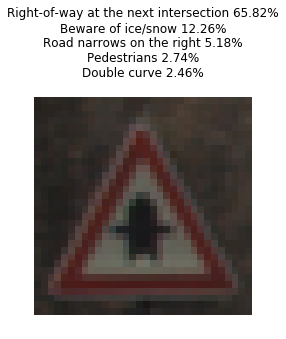

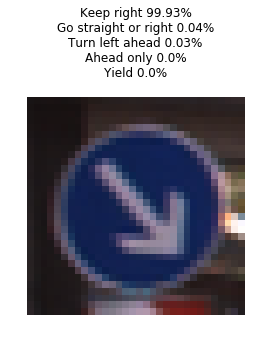

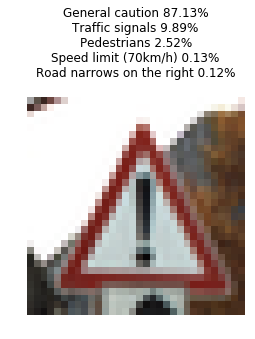

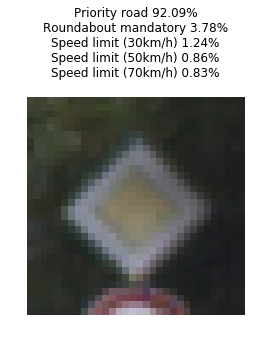

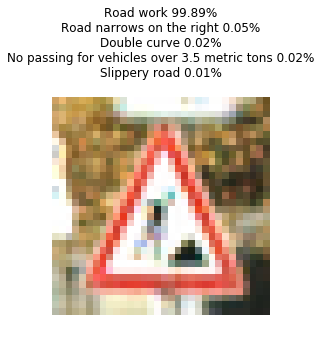

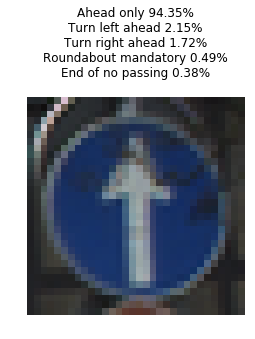

In [63]:
##### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
probs_op = tf.nn.softmax(logits)
top_k_op = tf.nn.top_k(probs_op, k=5)
top_k = []
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k = sess.run(top_k_op, feed_dict={x: signs_norm, keep_prob: 1.0})
prob_values, class_labels = top_k[0], top_k[1]

for i in range(0,10):
    title=''
    for certainty, label in zip(prob_values[i], class_labels[i]):
        title += sign_names[label] + ' ' + \
                    str(round(certainty* 100., 2)) + '%\n'
    plt.title(title)
    plt.axis('off')
    plt.imshow(image_list[i])
    plt.show()